`https://tutorials.pytorch.kr/beginner/fgsm_tutorial.html`
# 적대적 예재 생성(Adversarial Example Generation)
> 특정 노이즈 값을 이용해 의도적으로 오분류를 이끌어내는 입력값을 만들어낸 것을 의미.

        - Adversarial example(적대적 예제): 머신러닝 모델의 착시를 유도하는 입력
        - Adversarial attack(적대적 공격): 적대적 예제를 생성해서 여러 머신러닝 기반 시스템의 성능을 의도적으로 떨어뜨려, 보안문제를 일으키는 과정

> 대표적인 공격 방법

> FGSM, PGD: 주어진 모델의 weights 값을 이용해서 gradient 값을 계산하여 입력값을 조작할 수 있음.

<br><br>

# 위협 모델
상황에 따라 적대적 공격이 다양함. (각각 목표, 공격자가 알고 있는 정보도 다름)
> 가장 중요한 목표: 입력 데이터에 최소한 작은 변화를 추가하여 이것이 의도적으로 잘못 분류되게 하는 것.

<br><br>
공격자가 가진 정보에 대한 가정에는 여러 종류가 있음.
1. 화이트박스 공격: 공격자가 모델에 대해 (아키텍처, 입력, 출력, 가중치 등) 다 알고 있고, 접근 가능하다고 가정
2. 블랙박스 공격: 공격자가 모델의 입력, 출력에 대해서만 접근 가능하다고 가정
> 공격자의 목표: `오분류` 및 **소스/타겟 오분류**를 포함한 여러 유형이 있음.

-> `오분류의 목표`: 공격자가 출력으로 나온 분류 결과가 잘못 되도록 하나, 새로운 분류 결과가 어떤 것이 나오는지 신경 쓰지 않는 것을 의미

-> **소스/타겟 오분류의 목표**: 공격자가 원래 특정 소스 클래스의 이미지를 다른 특성 대상 클래스로 분류하도록 변경하로겨 함을 의미

<br><br>
이 경우 FGSM 공격은 `오분류`를 목표로하는 *화이트 박스 공격*이다.

<br><br>

# 빠른 변화도 부호 공격(FGSM)
학습 방식, 변화도(gradients)를 활용하여 신경망을 공격하도록 설계되어 있음.

역전파 변화도를 기반으로 가중치를 조정하여 손실을 최소화하기보다는 공격이 동일한 역전파 변화도를 기반으로 손실을 최대화하는 방향으로 입력 데이터를 조정함.

> 즉, 공격은 입력 데이터에서 계산된 손실 변화도를 사용하고, 입력 데이터를 조정하여 손실이 최대가 되게 함.


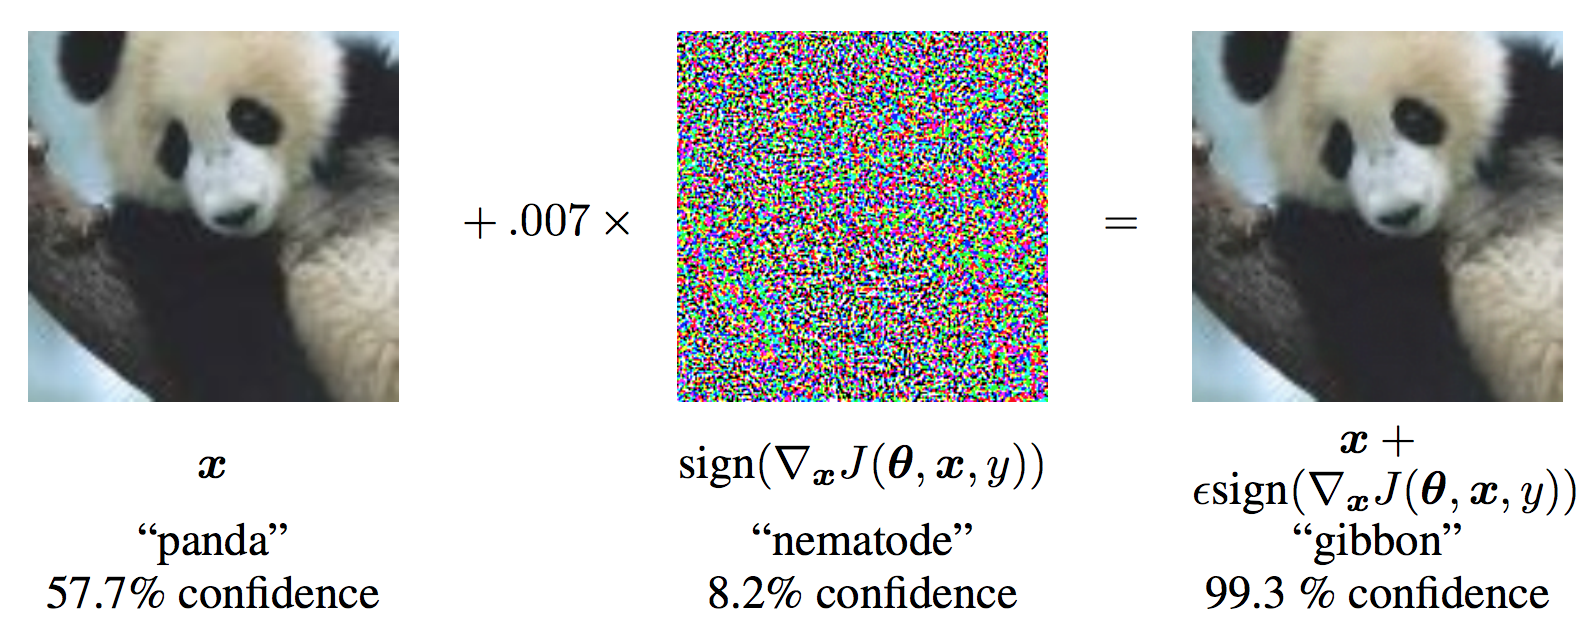

In [5]:
# 유명한 판다 예제
from IPython.display import Image
Image("image/fgsm_panda_image.png")

그림으로부터, $\mathbf{x}$ 는 원본 입력 이미지가 "판다" 로 올바르게 분류된 것을 의미하고,
$y$ 는 $\mathbf{x}$ 를 위한 정답 라벨이며, $\mathbf{\theta}$ 는 모델의
파라미터를, $J(\mathbf{\theta}, \mathbf{x}, y)$ 는 네트워크의 학습을 위해서 사용되는 손실을 나타냄.


공격은 $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$ 계산을 위해 입력 데이터에 변화도를 역전파함.
그러고 나서, 변화도는 손실 값이 최대화되는 방향으로 (예를 들면, $sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$ )
작은 스텝(step) 만큼 (그림에서는 $\epsilon$ 혹은 $0.007$) 입력 데이터에 적용됨.


> 결과로 나오는 작은 변화된 이미지( $x'$ )는 타겟 네트워크에 의해 "긴팔원숭이"로 *오분류* 되나 여전히 육안으로는 분명히 "판다" 임.

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: 아래는 MNIST 데이터셋을 내려받을 때 "User-agent" 관련한 제한을 푸는 코드
# 더 자세한 내용: https://github.com/pytorch/vision/issues/3497
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## 구현
튜토리얼의 입력 매개 변수에 대해 설명하고 공격중인 모델을 정의한 다음 공격을 코딩하고, 일부 테스트를 실행

## 입력
입력은 총 3개

1. **epsilons**: 실행에 사용할 엡실론의 리스트

    엡실론 0의 값은 원래 테스트 셋의 모델 성능을 나타내므로 목록에 유지하는 것이 중요함.

    또한 직관적으로 앱실론이 클 수록 작은 변화가 더 눈에 띄지만 모델 정확도를 저하 시키는 측면에서 더 효과가 있음.
    
    여기서 데이터의 범위는 0-1이기 때문에 앱실론의 값은 1을 초과할 수 없음.

2. **pretrained_model**: https://github.com/pytorch/examples/tree/main/mnist를 통해 미리 학습된 MNIST 모델의 경로, 튜토리얼을 간편하게 하려면 https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h 에서 미리 학습된 모델을 다운로드.

3. **use_cuda**: CUDA를 사용할지 말지는 정하는 이진 플래그.

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

## 공격을 받는 모델
공격 받는 모델은 https://github.com/pytorch/examples/tree/main/mnist와 동일한 MNIST 모델임.

본인의 MNIST 모델을 학습 및 저장하는 방식으로 하거나 제공된 모델을 다운로드해서 사용하는 방식으로 진행할 수 있음.

여기서 Net 정의 및 테스트 데이터 로드는 MNIST 예제에서 복사하였음.

> 목적: 모델과 데이터 로더를 정의하고, 모델을 초기화, 미리 학습된 가중치를 읽어오기

In [10]:
# LeNet 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST 테스트 데이터셋과 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 어떤 디바이스를 사용할지 정의
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 모델 초기화하기
model = Net().to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM 공격

이제 원래 입력을 교란시켜 적대적인 예를 만드는 함수를 정의 할 수 있음.

``fgsm_attack`` 함수는 입력 파라미터로 3가지를 가짐.

1. 원본 *이미지* ( $x$ )
2. *엡실론* 으로 픽셀 단위의 작은 변화를 주는 값( $\epsilon$ ).
3. *data_grad* 로 입력 영상 ( $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$ ) 에 대한 변화도 손실 값.

아래 식에 따른 작은 변화가 적용된 이미지를 생성함.

> `perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))`

마지막으로 데이터의 원래 범위를 유지하기 위해, 작은 변화가 적용된 이미지가 $[0,1]$ 범위로 잘립니다.

In [12]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad의 요소별 부호 값을 얻어옴.
    sign_data_grad = data_grad.sign()
    # 입럭 이미지의 각 픽셀에 sign_data_grad를 적용해 작은 변화가 적용된 이미지 생성함.
    perturbed_image = image + epsilon * sign_data_grad
    # 각 범위를 [0, 1]로 유지하기 위해 자르기(clipping)을 추가함.
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴함.
    return perturbed_image

## 테스팅 함수
마지막으로 본 튜토리얼의 핵심 결과는 ``테스트`` 함수에서 오게 됨.

이 테스트 기능을 호출할 때마다 MNIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 보고함.

> 이 함수에는 **엡실론** 입력도 필요: 이는 ``테스트`` 함수가 $\epsilon$ 크기에 따라 공격자의 공격을 받는 모델의 정확도를 보고하기 때문임.

더 구체적으로 보면 테스트 셋의 각각의 샘플에서 테스트 함수는 입력 데이터에 대한 손실 변화도( $data\_grad$ )를 계산하고,
``FGSM 공격`` ($perturbed\_data$) 을 받은 작은 변화가 적용된 이미지를 만들고 나서 작은 변화가 적용된 이미지가 적대적인지 확인함.

추가로 모델의 정확도를 테스트하기 위해서 테스트 함수는 나중에 시각화하여 볼 수 있도록 성공적으로 얻은 적대적 이미지를 저장하고 반환함.

In [13]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

## 공격 실행
구현의 마지막 부분은 공격을 실행하는 것.

여기서 전체 테스트 스텝을 각 **엡실론** 값에 실행함.

각 엡실론마다 최종 정확도와 성공적인 일부 적대 사례를 저장하여 다음 섹션에 표시.

엡실론 값이 증가함에 따라 출력된 정확도가 어떻게 감소하는지 보고, $\epsilon=0$ 인 경우에는 공격이 없는 원본 테스트 정확도임을 보임.


In [14]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


# 결과
정확도 vs 앱실론

첫 번째 결과는 정확도 vs 엡실론 을 도식화 한것.

앞에서 언급했듯이, 엡실론이 증가함에 따라 우리는 테스트 정확도가 감소할 것으로 예상함.

이는 학습을 더 진행해 갈수록 엡실론이 클수록 손실을 극대화 할 방향으로 진행되기 때문임.

엡실론 값이 선형적으로 분포하더라도 곡선의 추세는 선형의 형태가 아님.

예를 들면, math:`\epsilon=0.05` 에서의 정확도가 $\epsilon=0$ 보다 약 4% 낮지만
$\epsilon=0.2$ 에서의 정확도는 $\epsilon=0.15$ 보다 약 25% 정도 낮음.

또한, $\epsilon=0.25$ 와 $\epsilon=0.3$ 사이의 모델 정확도는 랜덤으로
10개중 1개를 선택했을 때의 정확도와 유사한 수준임.


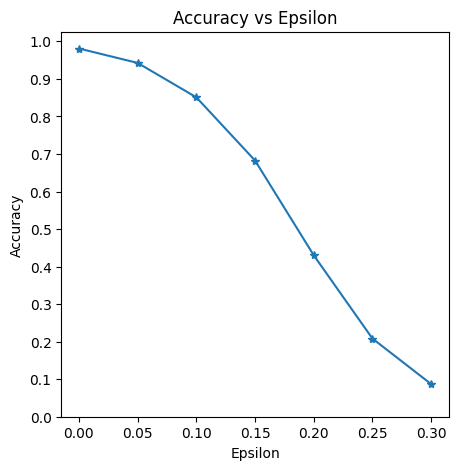

In [15]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## 샘플 적대적 예제들

이 경우에는 엡실론이 증가할수록 테스트 정확도는 떨어짐. 그러나 작은 변화는 더 쉽게 인식할 수 있게 됨.

실제로 정확도 저하와 공격자가 고려해야 하는 이해도 사이에는 상충 관계(tradeoff)가 있음.
<br><br>

### 각 엡실론 값에서 성공적인 대적 사례를 보이는 몇 가지 예시
    
아래 이미지의 첫번째로 열은 $\epsilon=0$ 인 예제들로 작은 변화가 없는 원본의 "깨끗한" 이미지들을 나타냄.

각 이미지의 위의 글자는 "원래 분류 결과 -> 적대적 분류 결과"를 나타냄.

$\epsilon=0.15$ 에서 작은 변화가 눈에 띄기 시작하고 $\epsilon=0.3$ 에서는 확실해 보임.

그러나 모든 경우에 대해서 노이즈가 추가되었더라도 사람은 올바르게 분류를 수행할 수 있음.

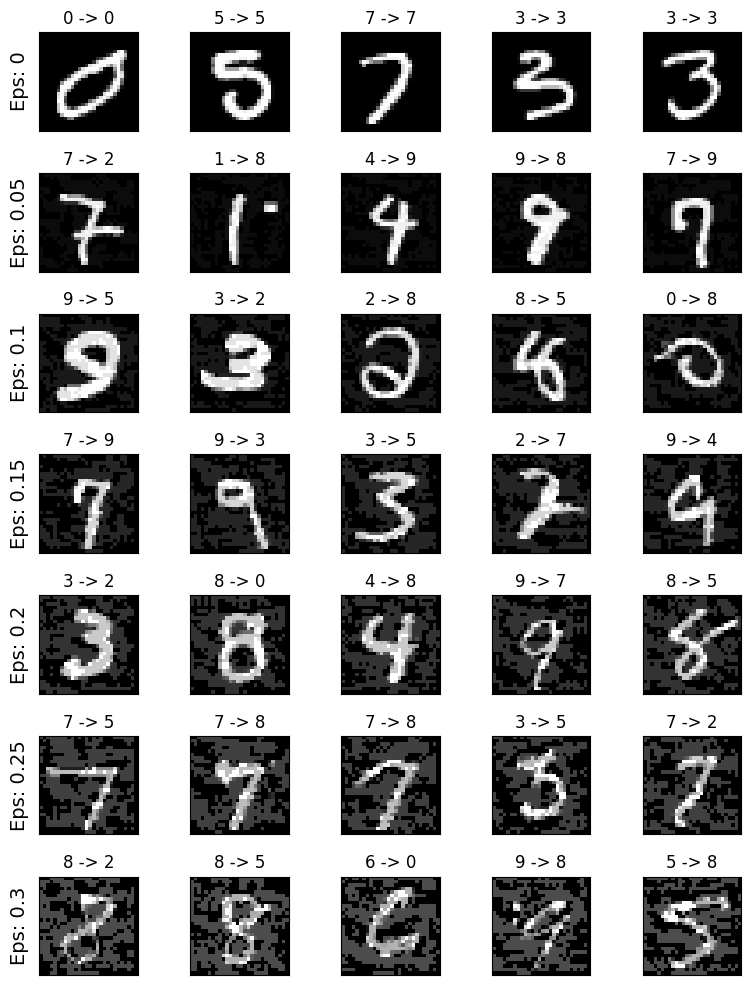

In [16]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()